# Задача №1: Метрики для оценки бизнеса

## 1. Оценка пользовательской активности

#### Описание 
Наша команда запустила новый сервис — доставку на дронах. Заказать услугу можно через мобильное приложение «Лечу не хочу». Услуга пользуется популярностью, и наша команда решила пойти к инвесторам. Найдём интересующие нас метрики.  
В файле `users_data.csv` хранятся действия пользователей приложения:
столбец `id` содержит идентификаторы пользователей,  
столбец `session_start_ts` хранит время начала сессии,  
столбец `session_end_ts` содержит время окончания сессии.  

### 1.1. Загрузка данных, осмотр и предобработка

Загрузим нужные библиотеки:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

Загрузим  файл `users_data.csv`:

In [2]:
users_data = pd.read_csv('https://code.s3.yandex.net/datasets/users_data.csv')# напишите ваш код здесь

In [3]:
users_data.head()

,session_end_ts,session_start_ts,id
0,2018-05-12 13:01:00,2018-05-12 12:59:00,6166747268563051447
1,2018-05-12 13:01:00,2018-05-12 13:01:00,14914378861449143644
2,2018-05-12 13:02:00,2018-05-12 13:00:00,3454575477456344412
3,2018-05-12 13:02:00,2018-05-12 13:02:00,630504356053318052
4,2018-05-12 13:03:00,2018-05-12 13:02:00,596727621648472758


Посмотрим общую информацию:

In [4]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105909 entries, 0 to 105908
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   session_end_ts    105909 non-null  object
 1   session_start_ts  105909 non-null  object
 2   id                105909 non-null  uint64
dtypes: object(2), uint64(1)
memory usage: 2.4+ MB


Мы видим,что в двух колонках с датами `session_end_ts` и `session_start_ts` тип данных стоит `object`. Надо изменить на тип `datetime`.

Проведём предобработку данных:

In [5]:
users_data['session_start_ts'] = pd.to_datetime(users_data['session_start_ts']) # изменим тип данных на datetime
users_data['session_end_ts'] = pd.to_datetime(users_data['session_end_ts']) # изменим тип данных на datetime
users_data['session_year'] = users_data['session_start_ts'].dt.year # создадим новый столбец с данными о годах
users_data['session_month'] = users_data['session_start_ts'].dt.month # создадим новый столбец с данными о месяцах
users_data['session_week'] = users_data['session_start_ts'].dt.isocalendar().week # создадим новый столбец с недельными данными
users_data['session_date'] = users_data['session_start_ts'].dt.date # создадим новый столбец с началом сессии в формате d/m/y

### 1.2 Cколько активных уникальных пользователей по месяцам?

In [6]:
users_data.groupby(by='session_month')['id'].nunique()

session_month
5    26975
6    33473
7    15839
Name: id, dtype: int64

### 1.3  Посчитаем количество уникальных активных пользователей за день, неделю и месяц:  DAU, WAU и MAU соответственно.

**Посчитаем MAU за весь период и сохраним результат в переменную `mau_total`.**

In [7]:
mau_total = (
    users_data.groupby(['session_year', 'session_month'])
    .agg({'id': 'nunique'})
    .mean()
)
print(int(mau_total))

25429


Приличное число активных пользователей за месяц! Инвесторы будут приятно удивлены!

**Посчитаем DAU и сохраним результат в переменную `dau_total`.**

In [8]:
dau_total =users_data.groupby('session_date').agg({'id': 'nunique'}).mean()
print(int(dau_total))

1536


**Посчитаем WAU и сохраним результат в переменную `wau_total`.**

In [9]:
wau_total =(
    users_data.groupby(['session_year', 'session_week'])
    .agg({'id': 'nunique'})
    .mean() 
)
print(int(wau_total))

8297


### 1.4 Найдём sticky factor в процентах по отношению к месячной и недельной аудитории**

**Посчитаем регулярность использования сервиса или приложения для недельной аудитории как DAU/WAU:**

In [10]:
sticky_wau =dau_total / wau_total * 100 # напишите ваш код здесь
print(sticky_wau)

id    18.512582
dtype: float64


**Посчитаем регулярность использования сервиса или приложения для месячной аудитории как DAU/MAU:**

In [11]:
sticky_mau = dau_total/mau_total*100# напишите ваш код здесь
print(sticky_mau)

id    6.040741
dtype: float64


Надеемся, что "липкий фактор" поможет впечатлить инвесторов. И "прилепит" их вложения к нашей компании.

### 1.5  Пользовательская сессия

**Посчитаем среднее число сессий на пользователя**

Для этого найдем количество сессий и количество пользователей и переименуем столбцы с этими данными.  
Назовем первый `n_sessions`, второй — `n_users`. Посчитаем количество сессий на одного пользователя по каждому месяцу.  

In [12]:
sessions_per_user = users_data.groupby(['session_year','session_month']).agg({'id': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
print(sessions_per_user)

                            n_sessions  n_users  sess_per_user
session_year session_month                                    
2018         5                   36716    26975       1.361112
             6                   47607    33473       1.422251
             7                   21586    15839       1.362839


Кажется, пользователи заходили сделать заказ и проверить его, но возвращались редко. Есть куда расти!

**Найдем продолжительность сессий и построим гистограмму со 100 корзинами.**

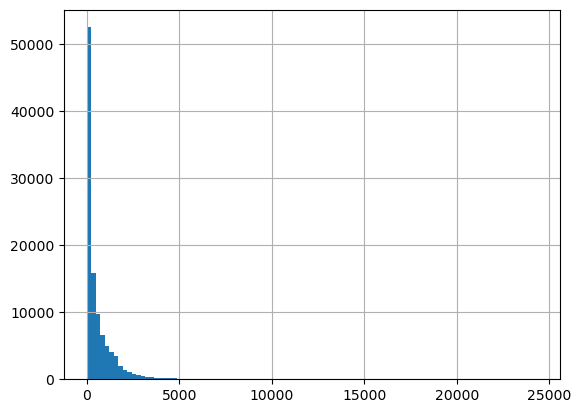

In [13]:
users_data['session_duration_sec'] =(
    users_data['session_end_ts'] - users_data['session_start_ts']
).dt.seconds  # посчитаем продолжительность сессий
users_data['session_duration_sec'].hist(bins=100)
plt.show() 

Длина сессий распределена неравномерно. Учтем это при расчёте средней продолжительности сессии.

## 2. Маркетинговая воронка: показы, клики, CTR и CR

**Описание**  

В компании «Волки и овцы» маркетологи размещают в интернете рекламные баннеры. Потенциальные клиенты иногда по ним кликают, после чего попадают на специальную посадочную страницу, или лендинг. Там есть форма регистрации, которую потенциальные клиенты заполняют, если рекламируемый продукт их заинтересовал.

### 2.1 Посчитаем CTR и конверсию кликов по рекламе в регистрацию на сайте

- Откроем данные о рекламных баннерах из файла `ad_data.csv` и сохраним в переменную `ad_data`.  
- Информацию о регистрациях пользователей получим из файла `site_data.csv` и сохраним в переменную `site_data`.  
- Объединим данные таблиц в один датафрейм по столбцу `date`.  
- Сохраним результат в переменную `funnel` и выведем на экран первые 5 строк получившегося датасета.  

In [14]:
ad_data = pd.read_csv ('https://code.s3.yandex.net/datasets/ad_data.csv')# загрузим данные из ad_data.csv
site_data = pd.read_csv ('https://code.s3.yandex.net/datasets/site_data.csv') # загрузим данные из site_data.csv
funnel =ad_data.merge (site_data, on = 'date') # объединим их по столбцу date

print(funnel.head(5))# выведем первые пять строк датафрейма funnel

         date  impressions  clicks  registrations
0  2019-08-01         6153      61              6
1  2019-08-02         8254      81              6
2  2019-08-03         4434      43              4
3  2019-08-04         9510      79              7
4  2019-08-05         7167      70              6


В переменной `funnel` маркетинговая воронка. Взглянем на данные:  
- `impressions`- количество показов рекламных баннеров в день;    
- `clicks`- количество кликов по баннерам;    
- `registrations` - количество зарегестрированных пользователей.  
Осталось посчитать конверсии на каждом шаге.  


In [15]:
funnel['ctr, %'] =funnel['clicks']/funnel['impressions']*100 # посчитаем CTR
funnel['cr, %'] =funnel['registrations']/funnel['clicks']*100 # посчитаем конверсию кликов в регистрации

print(funnel.head(5))# выведем первые пять строк датафрейма

         date  impressions  clicks  registrations    ctr, %     cr, %
0  2019-08-01         6153      61              6  0.991386  9.836066
1  2019-08-02         8254      81              6  0.981342  7.407407
2  2019-08-03         4434      43              4  0.969779  9.302326
3  2019-08-04         9510      79              7  0.830705  8.860759
4  2019-08-05         7167      70              6  0.976699  8.571429


Мы построили маркетинговую воронку за каждый день. Дневные метрики полезны, если нужно узнать, "что происходило в субботу". Однако для поиска закономерностей на более длинном горизонте такие данные не подходят- слишком много шума.

## 3. Маркетинговая воронка: группировка по неделям и месяцам.

### 3.1 Создадим воронку с конверсиями по неделям

- Загрузим данные о ежедневных конверсиях из файла `funnel_daily.csv`.  
- Переведем значения столбца `date` в формат `datetime`.  
- Добавим столбец `week` и посчитаем в нём номера недель для соответствующих дат.  
- Посчитаем недельные CTR и CR, сгруппировав датафрейм по столбцу `week`.  

In [16]:
funnel_daily =pd.read_csv('https://code.s3.yandex.net/datasets/funnel_daily.csv') # загрузим данные

funnel_daily['date'] = pd.to_datetime(funnel_daily['date'])# переведем значения в формат datetime
funnel_daily['week'] =funnel_daily['date'].dt.isocalendar().week # найдем номера недель для каждой даты

funnel_weekly = funnel_daily.groupby('week')[['impressions', 'clicks', 'registrations']].sum()# выполним группировку, сложив показы, клики и регистрации
funnel_weekly['ctr, %'] =funnel_weekly['clicks'] / funnel_weekly['impressions'] * 100 # посчитаем ctr
funnel_weekly['cr, %'] =funnel_weekly['registrations'] / funnel_weekly['clicks'] * 100 # посчитаем cr

print(funnel_weekly)

      impressions  clicks  registrations    ctr, %     cr, %
week                                                        
31          28351     264             23  0.931184  8.712121
32          57031     503             43  0.881976  8.548708
33          57184     471             39  0.823657  8.280255
34          49911     424             37  0.849512  8.726415
35          34956     307             25  0.878247  8.143322


По такой воронке делать выводы намного проще. Обратим внимание, что количество показов сильно увеличилось с 32 недели.А CTR и СR почти не изменились. Значит реклама работает: чем больше показов, тем больше регистраций.

### 3.2 Создадим воронку с конверсиями по месяцам

«Волки и овцы» познали силу аналитики и передали нам данные за все три месяца работы маркетологов. Построим дневную, недельную и месячную воронки.
- Прочитаем данные о расходах на рекламу из файла `ad_data_2.csv`, а данные о регистрациях — из файла `site_data_2.csv`. 
- Методом merge() объединим датафреймы по столбцу `date`. Посчитам дневные CTR и CR.  
- В объединённом датафрейме переведем данные столбца `date` в формат `datetime`.  
- Создадим столбцы `week` и `month` и сохраним в них порядковые номера недель и месяцев, полученные методами dt.week и dt.month соответственно.  
- Построим недельную воронку, как в предыдущей задаче. Таким же образом создадим воронку с конверсиями по месяцам.   

In [17]:
ad_data = pd.read_csv('https://code.s3.yandex.net/datasets/ad_data_2.csv')# считаем данные из 'ad_data_2.csv'
site_data = pd.read_csv('https://code.s3.yandex.net/datasets/site_data_2.csv')# считаем данные из 'site_data_2.csv'

In [18]:
funnel_daily = pd.merge(ad_data, site_data, on='date') # объединим датафреймы по date

Посчитаем дневной CTR и  дневной CR:

In [19]:
funnel_daily['ctr, %'] = funnel_daily['clicks']/funnel_daily['impressions'] * 100# посчитайте дневной CTR
funnel_daily['cr, %'] =funnel_daily['registrations']/funnel_daily['clicks'] *100 # посчитайте дневной CR

Преобразуем данные:

In [20]:
funnel_daily['date'] = pd.to_datetime(funnel_daily['date'])
funnel_daily['week'] = funnel_daily['date'].dt.isocalendar().week# получим порядковый номер недели из даты
funnel_daily['month'] =funnel_daily['date'].dt.month # получим порядковый номер месяца из даты

Сгруппируем данные и посчитаем недельный CTR и CR:

In [21]:
funnel_weekly = funnel_daily.groupby('week')[['impressions', 'clicks', 'registrations']].sum()# сгруппируем данные funnel_daily методом groupby() по столбцу 'week'
# данные столбцов ['impressions', 'clicks', 'registrations'] просуммируем внутри группировки.
##funnel_weekly = # выполним группировку и суммирование
funnel_weekly['ctr, %'] = funnel_weekly['clicks']/funnel_weekly['impressions'] * 100# посчитаем недельный CTR
funnel_weekly['cr, %'] = funnel_weekly['registrations']/funnel_weekly['clicks'] *100# посчитаем недельный CR

Сгруппируем данные и посчитаем месячный CTR и CR:

In [22]:
# сгруппируем данные funnel_daily методом groupby() по столбцу 'month'
# данные столбцов ['impressions', 'clicks', 'registrations'] просуммируем внутри группировки.
funnel_monthly =funnel_daily.groupby('month')[['impressions', 'clicks', 'registrations']].sum() # выполним группировку и суммирование
funnel_monthly['ctr, %'] = funnel_monthly['clicks']/funnel_monthly['impressions'] * 100# посчитаем месячный CTR
funnel_monthly['cr, %'] = funnel_monthly['registrations']/funnel_monthly['clicks'] *100# посчитаем месячный CR
print(funnel_monthly)

       impressions  clicks  registrations    ctr, %     cr, %
month                                                        
1           197929    1462            118  0.738649  8.071135
2           188815    1447            103  0.766359  7.118176
3           214317    1710            122  0.797884  7.134503


Все данные как на ладони. CTR постепенно растёт от месяца к месяцу(от 0,73% до 0,79%), но CR немного снизился. Посетители всё реже превращаются в покупателей. Стоит исследовать, с чем это может быть связано.

# Задача №2: Нам необходимо понять какие цели отслеживаются на странице https://www.open.ru/cards/opencard?from=main_menu .

### Чтобы работать с информацией из интернета нам понадобятся два модуля:   
1). Модуль для запроса страниц из Сети  
2). Модуль для извлечения информации из Страниц

In [23]:
import requests
from bs4 import BeautifulSoup

### Запросим файл страницы из сети:

In [24]:
url = 'https://www.open.ru/cards/opencard?from=main_menu'

page = requests.get(url)

### Проверим что она загрузилась, посмотрев на статус страницы :

In [25]:
print(f'Страница загрузилась с кодом {page.status_code}')

Страница загрузилась с кодом 200


### Посмотрим на содержимое файла страницы из Сети :

In [26]:
print(page.text)

<!DOCTYPE html><html><head><meta content="text/html; charset=utf-8" http-equiv="Content-Type" /><meta content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no" name="viewport" /><meta content="IE=edge" http-equiv="X-UA-Compatible" /><link rel="apple-touch-icon" type="image/png" href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_57-a3c763250c283fd1f8a6980525463c08.png" sizes="57x57" /><link rel="apple-touch-icon" type="image/png" href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_60-b3bf6546955cc936904b7cfc361013f3.png" sizes="60x60" /><link rel="apple-touch-icon" type="image/png" href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_72-dbfbb9278e313556cad4b51ff6d715c6.png" sizes="72x72" /><link rel="apple-touch-icon" type="image/png" href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_76-1768f529f6ac8e9c69185c12825d81d3.png" sizes="76x76" /><link rel="apple-touch-icon" type="image

### Посмотрим на содержимое файла страницы из Сети, установив правильную кодировку:

In [27]:
page.encoding = "utf-8"
print(page.text)

<!DOCTYPE html><html><head><meta content="text/html; charset=utf-8" http-equiv="Content-Type" /><meta content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no" name="viewport" /><meta content="IE=edge" http-equiv="X-UA-Compatible" /><link rel="apple-touch-icon" type="image/png" href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_57-a3c763250c283fd1f8a6980525463c08.png" sizes="57x57" /><link rel="apple-touch-icon" type="image/png" href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_60-b3bf6546955cc936904b7cfc361013f3.png" sizes="60x60" /><link rel="apple-touch-icon" type="image/png" href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_72-dbfbb9278e313556cad4b51ff6d715c6.png" sizes="72x72" /><link rel="apple-touch-icon" type="image/png" href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_76-1768f529f6ac8e9c69185c12825d81d3.png" sizes="76x76" /><link rel="apple-touch-icon" type="image

### Распознаем код страницы с помощью BeautifulSoup:

In [28]:
soup = BeautifulSoup(page.text)
print(soup)

<!DOCTYPE html>
<html><head><meta content="text/html; charset=utf-8" http-equiv="Content-Type"/><meta content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no" name="viewport"/><meta content="IE=edge" http-equiv="X-UA-Compatible"/><link href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_57-a3c763250c283fd1f8a6980525463c08.png" rel="apple-touch-icon" sizes="57x57" type="image/png"/><link href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_60-b3bf6546955cc936904b7cfc361013f3.png" rel="apple-touch-icon" sizes="60x60" type="image/png"/><link href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_72-dbfbb9278e313556cad4b51ff6d715c6.png" rel="apple-touch-icon" sizes="72x72" type="image/png"/><link href="https://cdn.open.ru/packs/media/src/front/images/apple-touch-icon_76-1768f529f6ac8e9c69185c12825d81d3.png" rel="apple-touch-icon" sizes="76x76" type="image/png"/><link href="https://cdn.open.ru/packs/media/sr

### Найдём все ссылки на сайте:

In [29]:
print(soup.find_all('a'))

[<a class="open-logo open-logo__bank_black" href="/"></a>, <a class="nav-list__link" href="/credits/cash?from=temp_menu">Кредиты</a>, <a class="nav-list__link" href="/credit_cards?from=temp_menu">Кредитные карты</a>, <a class="nav-list__link" href="/cards?from=temp_menu">Дебетовые карты</a>, <a class="nav-list__link" href="/ipoteka?from=temp_menu">Ипотека</a>, <a class="nav-list__link" href="/autocredits?from=temp_menu">Автокредиты</a>, <a class="nav-list__link" href="/deposits?from=temp_menu">Вклады и счета</a>, <a class="nav-list__link" href="/investments?from=temp_menu">Инвестиции</a>, <a class="nav-list__link nowrap" href="https://ib.open.ru/webbank/">Интернет-банк</a>, <a class="nav-list__link" href="/credits/cash?from=temp_menu">Кредиты</a>, <a class="nav-list__link" href="/credit_cards?from=temp_menu">Кредитные карты</a>, <a class="nav-list__link" href="/cards?from=temp_menu">Дебетовые карты</a>, <a class="nav-list__link" href="/ipoteka?from=temp_menu">Ипотека</a>, <a class="nav

### Найдём все ссылки на сайте и посмотрим их список с помощью цикла for:

In [30]:
for link in soup.find_all('a'):
    print(link)

<a class="open-logo open-logo__bank_black" href="/"></a>
<a class="nav-list__link" href="/credits/cash?from=temp_menu">Кредиты</a>
<a class="nav-list__link" href="/credit_cards?from=temp_menu">Кредитные карты</a>
<a class="nav-list__link" href="/cards?from=temp_menu">Дебетовые карты</a>
<a class="nav-list__link" href="/ipoteka?from=temp_menu">Ипотека</a>
<a class="nav-list__link" href="/autocredits?from=temp_menu">Автокредиты</a>
<a class="nav-list__link" href="/deposits?from=temp_menu">Вклады и счета</a>
<a class="nav-list__link" href="/investments?from=temp_menu">Инвестиции</a>
<a class="nav-list__link nowrap" href="https://ib.open.ru/webbank/">Интернет-банк</a>
<a class="nav-list__link" href="/credits/cash?from=temp_menu">Кредиты</a>
<a class="nav-list__link" href="/credit_cards?from=temp_menu">Кредитные карты</a>
<a class="nav-list__link" href="/cards?from=temp_menu">Дебетовые карты</a>
<a class="nav-list__link" href="/ipoteka?from=temp_menu">Ипотека</a>
<a class="nav-list__link" h

### Найдём все ссылки href и посмотрим их список с помощью цикла for:

In [31]:
for link in soup.find_all('a'):
    print(link.get('href'))

/
/credits/cash?from=temp_menu
/credit_cards?from=temp_menu
/cards?from=temp_menu
/ipoteka?from=temp_menu
/autocredits?from=temp_menu
/deposits?from=temp_menu
/investments?from=temp_menu
https://ib.open.ru/webbank/
/credits/cash?from=temp_menu
/credit_cards?from=temp_menu
/cards?from=temp_menu
/ipoteka?from=temp_menu
/autocredits?from=temp_menu
/deposits?from=temp_menu
/investments?from=temp_menu
https://ib.open.ru/webbank/
None
/cards
/cards
None
/cards
/cards
None
/cards
/cards
/mch1#5578
https://mobile.open.ru
https://ib.open.ru
https://cdn.open.ru/storage/files/tariff_opencard_debit.pdf
https://cdn.open.ru/storage/files/FAQ_Opencard.pdf
https://cdn.open.ru/storage/files/Opencard_Free.pdf
/bankomats
https://cdn.open.ru/storage/files/action_bonus_partners.pdf
https://travel.open.ru/
/sms-info
/security
https://cdn.open.ru/storage/files/Salary_transfer_application.pdf
tel:800
tel:8 800 444 44 00
tel:+7 495 224 44 00
https://www.open.ru/credits/cash?from=main_footer
https://www.open.ru

### Найдём все текстовые ссылки посмотрим их список с помощью цикла for:

In [32]:
for link in soup.find_all('a'):
    print(link.text)


Кредиты
Кредитные карты
Дебетовые карты
Ипотека
Автокредиты
Вклады и счета
Инвестиции
Интернет-банк
Кредиты
Кредитные карты
Дебетовые карты
Ипотека
Автокредиты
Вклады и счета
Инвестиции
Интернет-банк
Оформить карту

Дебетовые карты


Дебетовые карты

Оформить карту

Дебетовые карты


Дебетовые карты

Оформить карту

Дебетовые карты


Дебетовые карты

в некоторых категориях
Cкачать приложение
Перейти в интернет-банк
Тарифы по карте «Opencard»
Вопросы и ответы по Opencard
Правила акции «Бесплатная Opencard»
Как пополнять карту
Правила акции «Повышенные бонусы от партнеров»
Travel-портал
Уведомления по карте
Безопасность
Заявление на перечисление зарплаты на карту
800
8 800 444 44 00
+7 495 224 44 00
Потребительские кредиты
Дебетовые карты
Кредитные карты
Вклады и счета
Ипотека
Автокредиты
Наличные с покупкой
Премиальное обслуживание
Инвестиции
Страхование
Скидки и акции
Зарплатным клиентам
Пенсионерам
Монеты
Слитки из драгоценных металлов 
Поддержка клиентов
Общая информация
Реквизиты
К

Думаю, главное мы сделали,цели достигнуты!